# Obtained_data:

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, roc_auc_score, roc_curve, auc,
    confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
)

import tensorflow as tf
from tensorflow.keras import layers, models

from scipy.sparse import csr_matrix, hstack

In [2]:

user_data=pd.read_csv("Final_User_Dataset.csv")
item_data=pd.read_csv("Final_Anime_Dataset.csv")
user_input=pd.read_csv("User_input.csv")



C:\Users\Anshuman Raj\AppData\Local\Temp\ipykernel_26048\3708410406.py:2: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  item_data=pd.read_csv("Final_Anime_Dataset.csv")


In [3]:
user_data[user_data.columns[21]].dtype

dtype('float64')

In [4]:
user_data.iloc[21, :].unique()

array([np.int64(347), 'troublesome4u', 'Male', np.float64(8.64),
       np.float64(167.0), np.float64(8.84), np.float64(8.83),
       np.float64(7.93), np.float64(9.56), np.float64(7.06),
       np.float64(8.1), np.float64(8.67), np.float64(8.0),
       np.float64(6.8), np.float64(8.47), np.float64(7.17),
       np.float64(7.53), np.float64(6.47), np.float64(8.54),
       np.float64(6.83), np.float64(8.57), np.float64(8.32),
       np.float64(7.87), np.float64(9.0), np.float64(8.69),
       np.float64(10.0), np.int64(47), 'Gen_X', np.int64(0), np.int64(1)],
      dtype=object)

In [5]:
class GenreRatingTypeConverter(BaseEstimator, TransformerMixin):
    def __init__(self, column_prefix='avg_', errors='coerce', downcast=None):
        self.column_prefix = column_prefix
        self.errors = errors
        self.downcast = downcast
        self.columns_converted_ = None
    
    def fit(self, X, y=None):
        self.columns_converted_ = [col for col in X.columns if col.startswith(self.column_prefix)]
        return self
    
    def transform(self, X):
        X_result = X.copy()
        for column in self.columns_converted_:
            X_result[column] = pd.to_numeric(X_result[column], errors=self.errors, downcast=self.downcast)
        return X_result
    
    def get_feature_names_out(self, input_features=None):
        return self.columns_converted_


In [6]:
genre_converter = GenreRatingTypeConverter(column_prefix='avg_', errors='coerce')
user_data = genre_converter.fit_transform(user_data)
for col in genre_converter.columns_converted_:
    print(f"{col}: {user_data[col].dtype}")


avg_Action: float64
avg_Adventure: float64
avg_Avant Garde: float64
avg_Award Winning: float64
avg_Boys Love: float64
avg_Comedy: float64
avg_Drama: float64
avg_Ecchi: float64
avg_Erotica: float64
avg_Fantasy: float64
avg_Girls Love: float64
avg_Gourmet: float64
avg_Hentai: float64
avg_Horror: float64
avg_Mystery: float64
avg_Romance: float64
avg_Sci-Fi: float64
avg_Slice of Life: float64
avg_Sports: float64
avg_Supernatural: float64
avg_Suspense: float64


In [7]:
user_data["avg_Romance"].dtype

dtype('float64')

In [8]:
min_value = user_data['avg_Mystery'].min()
max_value = user_data['avg_Mystery'].max()
print(f"Range of avg_Mystery: {min_value} to {max_value}")

Range of avg_Mystery: 1.0 to 10.0


In [9]:
user_data["avg_Mystery"].dtype

dtype('float64')

In [10]:
item_data.shape

(19848, 1571)

In [11]:
user_data.columns

Index(['user_id', 'Username', 'Gender', 'Mean Score', 'Completed',
       'avg_Action', 'avg_Adventure', 'avg_Avant Garde', 'avg_Award Winning',
       'avg_Boys Love', 'avg_Comedy', 'avg_Drama', 'avg_Ecchi', 'avg_Erotica',
       'avg_Fantasy', 'avg_Girls Love', 'avg_Gourmet', 'avg_Hentai',
       'avg_Horror', 'avg_Mystery', 'avg_Romance', 'avg_Sci-Fi',
       'avg_Slice of Life', 'avg_Sports', 'avg_Supernatural', 'avg_Suspense',
       'Age', 'Viewer_Category', 'Age_Group__Gen_Alpha', 'Age_Group__Zoomers',
       'Age_Group__Millennials', 'Age_Group__Gen_X', 'Age_Group__Boomers_Plus',
       'Category_Classic_Era_Fans', 'Category_Gen_Alpha_Viewers',
       'Category_Millennial_Favorites', 'Category_Retro_Anime_Lovers',
       'Category_Zoomer_Picks'],
      dtype='object')

In [12]:
item_data.columns
item_data.sample()

,anime_id,Name,English name,Other name,Score,Genres,Synopsis,Episodes,Aired,Premiered,...,"Studio_pH Studio, D & D Pictures","Studio_pH Studio, Noovo",Studio_production doA,Studio_studio MOTHER,Studio_studio YOG,Studio_trenova,Studio_ufotable,"Studio_ufotable, Shaft, A-1 Pictures, SILVER LINK., Lerche, Lay-duce, CloverWorks, Drive","Studio_ufotable, feel., Studio Flag",Release_Year
17695,50810,Mao Zhi Ming Episode 5.5,Cat's Tea Episode 5.5,UNKNOWN,NaN,"Comedy, Fantasy",A special episode listed as 5.5 on bilibili.,1,"Nov 22, 2021",UNKNOWN,...,0,0,0,0,0,0,0,0,0,2021.0


In [13]:
encoder = OneHotEncoder(sparse_output=False, drop=None, dtype=int)
gender_encoded = encoder.fit_transform(user_data[['Gender']])
gender_columns = encoder.get_feature_names_out(['Gender'])
gender_encoded_df = pd.DataFrame(gender_encoded, columns=gender_columns)
user_data = pd.concat([user_data, gender_encoded_df], axis=1)
user_data.drop(columns=['Gender'], inplace=True)
print(user_data.head())


   user_id  Username  Mean Score  Completed  avg_Action  avg_Adventure  \
0        1     Xinil        7.37      233.0        7.68           7.90   
1       20    vondur        8.06       94.0        8.02           8.24   
2       66    Hiromi        7.53      148.0        7.49           7.31   
3       82    Achtor        7.17      153.0        7.36           7.71   
4      112  luffykun        8.77      125.0        8.60           8.36   

   avg_Avant Garde  avg_Award Winning  avg_Boys Love  avg_Comedy  ...  \
0             8.00               8.18           7.06        7.02  ...   
1             9.00               8.43           7.06        7.77  ...   
2             7.00               7.90           7.06        7.46  ...   
3             8.80               8.25           7.06        7.05  ...   
4             7.93               9.80           7.06        8.67  ...   

   Age_Group__Gen_X  Age_Group__Boomers_Plus  Category_Classic_Era_Fans  \
0                 1                      

In [14]:
item_data["Rating"].values

array(['R - 17+ (violence & profanity)', 'R - 17+ (violence & profanity)',
       'PG-13 - Teens 13 or older', ..., 'PG-13 - Teens 13 or older',
       'PG-13 - Teens 13 or older', 'PG-13 - Teens 13 or older'],
      dtype=object)

In [15]:
user_data.shape

(71278, 40)

In [16]:
user_data.columns

Index(['user_id', 'Username', 'Mean Score', 'Completed', 'avg_Action',
       'avg_Adventure', 'avg_Avant Garde', 'avg_Award Winning',
       'avg_Boys Love', 'avg_Comedy', 'avg_Drama', 'avg_Ecchi', 'avg_Erotica',
       'avg_Fantasy', 'avg_Girls Love', 'avg_Gourmet', 'avg_Hentai',
       'avg_Horror', 'avg_Mystery', 'avg_Romance', 'avg_Sci-Fi',
       'avg_Slice of Life', 'avg_Sports', 'avg_Supernatural', 'avg_Suspense',
       'Age', 'Viewer_Category', 'Age_Group__Gen_Alpha', 'Age_Group__Zoomers',
       'Age_Group__Millennials', 'Age_Group__Gen_X', 'Age_Group__Boomers_Plus',
       'Category_Classic_Era_Fans', 'Category_Gen_Alpha_Viewers',
       'Category_Millennial_Favorites', 'Category_Retro_Anime_Lovers',
       'Category_Zoomer_Picks', 'Gender_Female', 'Gender_Male',
       'Gender_Non-Binary'],
      dtype='object')

In [17]:
item_data.columns


Index(['anime_id', 'Name', 'English name', 'Other name', 'Score', 'Genres',
       'Synopsis', 'Episodes', 'Aired', 'Premiered',
       ...
       'Studio_pH Studio, D & D Pictures', 'Studio_pH Studio, Noovo',
       'Studio_production doA', 'Studio_studio MOTHER', 'Studio_studio YOG',
       'Studio_trenova', 'Studio_ufotable',
       'Studio_ufotable, Shaft, A-1 Pictures, SILVER LINK., Lerche, Lay-duce, CloverWorks, Drive',
       'Studio_ufotable, feel., Studio Flag', 'Release_Year'],
      dtype='object', length=1571)

In [18]:

item_data.isna().sum()

anime_id                                                                                       0
Name                                                                                           0
English name                                                                                   0
Other name                                                                                     0
Score                                                                                       5183
                                                                                            ... 
Studio_trenova                                                                                 0
Studio_ufotable                                                                                0
Studio_ufotable, Shaft, A-1 Pictures, SILVER LINK., Lerche, Lay-duce, CloverWorks, Drive       0
Studio_ufotable, feel., Studio Flag                                                            0
Release_Year                  

In [19]:
class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop=None):
        self.columns_to_drop = columns_to_drop if columns_to_drop else []

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.drop(columns=self.columns_to_drop, errors='ignore')
        return X_transformed

default_columns_to_drop = [
    "Genres", "Episodes", "Rating_UNKNOWN", "Producers", "Aired",
    "Premiered", "Status", "Studios", "Licensors", "Duration"
]

pipeline = Pipeline([
    ('column_dropper', ColumnDropper(columns_to_drop=default_columns_to_drop))
])

filtered_item_data_df = pipeline.fit_transform(item_data)

print(filtered_item_data_df.head())


   anime_id                             Name             English name  \
0         1                     Cowboy Bebop             Cowboy Bebop   
1         5  Cowboy Bebop: Tengoku no Tobira  Cowboy Bebop: The Movie   
2         6                           Trigun                   Trigun   
3         7               Witch Hunter Robin       Witch Hunter Robin   
4         8                   Bouken Ou Beet   Beet the Vandel Buster   

                         Other name  Score  \
0                         カウボーイビバップ   8.75   
1                    カウボーイビバップ 天国の扉   8.38   
2                             トライガン   8.22   
3  Witch Hunter ROBIN (ウイッチハンターロビン)   7.25   
4                            冒険王ビィト   6.94   

                                            Synopsis    Source  \
0  Crime is timeless. By the year 2071, humanity ...  Original   
1  Another day, another bounty—such is the life o...  Original   
2  Vash the Stampede is the man with a $$60,000,0...     Manga   
3  Robin Sena is a p

In [20]:
filtered_item_data_df.columns

Index(['anime_id', 'Name', 'English name', 'Other name', 'Score', 'Synopsis',
       'Source', 'Rating', 'Rank', 'Popularity',
       ...
       'Studio_pH Studio, D & D Pictures', 'Studio_pH Studio, Noovo',
       'Studio_production doA', 'Studio_studio MOTHER', 'Studio_studio YOG',
       'Studio_trenova', 'Studio_ufotable',
       'Studio_ufotable, Shaft, A-1 Pictures, SILVER LINK., Lerche, Lay-duce, CloverWorks, Drive',
       'Studio_ufotable, feel., Studio Flag', 'Release_Year'],
      dtype='object', length=1562)

In [21]:
filtered_item_data_df.shape
filtered_item_data_df.sample(5)

,anime_id,Name,English name,Other name,Score,Synopsis,Source,Rating,Rank,Popularity,...,"Studio_pH Studio, D & D Pictures","Studio_pH Studio, Noovo",Studio_production doA,Studio_studio MOTHER,Studio_studio YOG,Studio_trenova,Studio_ufotable,"Studio_ufotable, Shaft, A-1 Pictures, SILVER LINK., Lerche, Lay-duce, CloverWorks, Drive","Studio_ufotable, feel., Studio Flag",Release_Year
4823,7452,Mini Moni Yaru no da Pyon!,UNKNOWN,ミニモニ。やるのだぴょん,5.00,The very tiny adventures of the equally tiny b...,Other,G - All Ages,11957,14686,...,0,0,0,0,0,0,0,0,0,2001.0
7516,19177,Chiisana Love Letter: Mariko to Nemunoki no Ko...,UNKNOWN,小さなラブレター まり子とねむの木の子供たち,NaN,A follow-up to the same studio's Helen Keller ...,Unknown,PG-13 - Teens 13 or older,15236,16311,...,0,0,0,0,0,0,0,0,0,1981.0
15503,44016,Baobei Nuer Hao Mama: Kuaile De Jiating,UNKNOWN,宝贝女儿好妈妈之快乐的家庭,NaN,No description available for this anime.,Original,PG - Children,14828,22173,...,0,0,0,0,0,0,0,0,0,2012.0
5358,9040,Mokei Senshi Gunpla Builders Beginning G,UNKNOWN,模型戦士 ガンプラ ビルダーズ ビギニングG,6.58,"Haru Irei, who witnessed the 1/1 scale RX-78-2...",Unknown,G - All Ages,5913,7731,...,0,0,0,0,0,0,0,0,0,2010.0
7191,17443,Kyojin no Hoshi: Ike Ike Hyuuma,UNKNOWN,巨人の星 行け行け飛雄馬,NaN,Second Kyojin no Hoshi movie.,Unknown,G - All Ages,17585,15125,...,0,0,0,0,0,0,0,0,0,1969.0


In [22]:
filtered_item_data_df["Score"].isna().sum()

np.int64(5183)

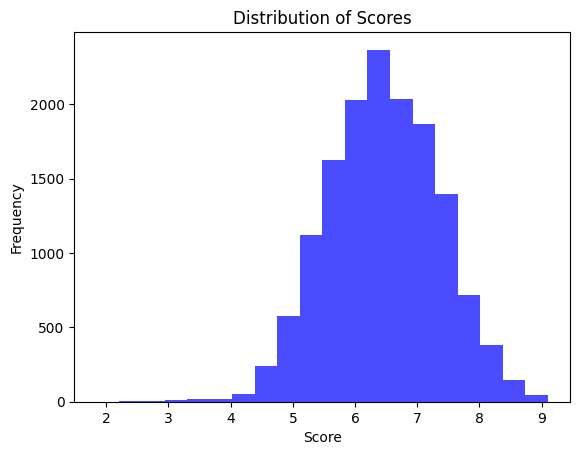

In [23]:
plt.hist(filtered_item_data_df['Score'].dropna(), bins=20, color='blue', alpha=0.7)
plt.title('Distribution of Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()


In [24]:
def impute_score_column(filtered_item_data_df):
    filtered_item_data_df['Score'] = filtered_item_data_df['Score'].replace('UNKNOWN', pd.NA)
    filtered_item_data_df['Score'] = filtered_item_data_df['Score'].astype(float).fillna(filtered_item_data_df['Score'].astype(float).mean())
    return filtered_item_data_df

impute_score_transformer = FunctionTransformer(impute_score_column)
filtered_item_data_df = impute_score_transformer.transform(filtered_item_data_df)
print(filtered_item_data_df['Score'].isna().sum())


0


In [25]:
def filter_score_and_release_year(df):
    """
    Filters rows where both 'Score' and 'Release_Year' are not null.

    Parameters:
    -----------
    df : pandas.DataFrame
        The input DataFrame to filter.

    Returns:
    --------
    pandas.DataFrame
        The filtered DataFrame.
    """
    return df[df["Score"].notna() & df["Release_Year"].notna()]

filter_transformer = FunctionTransformer(filter_score_and_release_year)

filtered_item_data_df = filter_transformer.transform(filtered_item_data_df)

print(filtered_item_data_df.head())


   anime_id                             Name             English name  \
0         1                     Cowboy Bebop             Cowboy Bebop   
1         5  Cowboy Bebop: Tengoku no Tobira  Cowboy Bebop: The Movie   
2         6                           Trigun                   Trigun   
3         7               Witch Hunter Robin       Witch Hunter Robin   
4         8                   Bouken Ou Beet   Beet the Vandel Buster   

                         Other name  Score  \
0                         カウボーイビバップ   8.75   
1                    カウボーイビバップ 天国の扉   8.38   
2                             トライガン   8.22   
3  Witch Hunter ROBIN (ウイッチハンターロビン)   7.25   
4                            冒険王ビィト   6.94   

                                            Synopsis    Source  \
0  Crime is timeless. By the year 2071, humanity ...  Original   
1  Another day, another bounty—such is the life o...  Original   
2  Vash the Stampede is the man with a $$60,000,0...     Manga   
3  Robin Sena is a p

In [26]:
print(filtered_item_data_df.isna().sum())

anime_id                                                                                    0
Name                                                                                        0
English name                                                                                0
Other name                                                                                  0
Score                                                                                       0
                                                                                           ..
Studio_trenova                                                                              0
Studio_ufotable                                                                             0
Studio_ufotable, Shaft, A-1 Pictures, SILVER LINK., Lerche, Lay-duce, CloverWorks, Drive    0
Studio_ufotable, feel., Studio Flag                                                         0
Release_Year                                                

In [27]:
filtered_item_data_df.shape

(19848, 1562)

In [28]:
user_data.columns

Index(['user_id', 'Username', 'Mean Score', 'Completed', 'avg_Action',
       'avg_Adventure', 'avg_Avant Garde', 'avg_Award Winning',
       'avg_Boys Love', 'avg_Comedy', 'avg_Drama', 'avg_Ecchi', 'avg_Erotica',
       'avg_Fantasy', 'avg_Girls Love', 'avg_Gourmet', 'avg_Hentai',
       'avg_Horror', 'avg_Mystery', 'avg_Romance', 'avg_Sci-Fi',
       'avg_Slice of Life', 'avg_Sports', 'avg_Supernatural', 'avg_Suspense',
       'Age', 'Viewer_Category', 'Age_Group__Gen_Alpha', 'Age_Group__Zoomers',
       'Age_Group__Millennials', 'Age_Group__Gen_X', 'Age_Group__Boomers_Plus',
       'Category_Classic_Era_Fans', 'Category_Gen_Alpha_Viewers',
       'Category_Millennial_Favorites', 'Category_Retro_Anime_Lovers',
       'Category_Zoomer_Picks', 'Gender_Female', 'Gender_Male',
       'Gender_Non-Binary'],
      dtype='object')

In [29]:
filtered_item_data_df.columns

Index(['anime_id', 'Name', 'English name', 'Other name', 'Score', 'Synopsis',
       'Source', 'Rating', 'Rank', 'Popularity',
       ...
       'Studio_pH Studio, D & D Pictures', 'Studio_pH Studio, Noovo',
       'Studio_production doA', 'Studio_studio MOTHER', 'Studio_studio YOG',
       'Studio_trenova', 'Studio_ufotable',
       'Studio_ufotable, Shaft, A-1 Pictures, SILVER LINK., Lerche, Lay-duce, CloverWorks, Drive',
       'Studio_ufotable, feel., Studio Flag', 'Release_Year'],
      dtype='object', length=1562)

In [30]:
user_input.columns

Index(['Username', 'Gender', 'Mean Score', 'Completed', 'Birth_Year',
       'user_id', 'anime_id', 'Anime Title', 'rating', 'Genres',
       'Genre_Action', 'Genre_Adventure', 'Genre_Avant Garde',
       'Genre_Award Winning', 'Genre_Boys Love', 'Genre_Comedy', 'Genre_Drama',
       'Genre_Ecchi', 'Genre_Erotica', 'Genre_Fantasy', 'Genre_Girls Love',
       'Genre_Gourmet', 'Genre_Hentai', 'Genre_Horror', 'Genre_Mystery',
       'Genre_Romance', 'Genre_Sci-Fi', 'Genre_Slice of Life', 'Genre_Sports',
       'Genre_Supernatural', 'Genre_Suspense'],
      dtype='object')

In [31]:

columns_with_unknown = filtered_item_data_df.columns[filtered_item_data_df.isin(['UNKNOWN']).any()]

print("Columns containing 'UNKNOWN':", list(columns_with_unknown))


Columns containing 'UNKNOWN': ['English name', 'Other name', 'Scored By']


In [32]:
unknown_counts = filtered_item_data_df.isin(['UNKNOWN']).sum().sum()
print(f"Total instances with 'UNKNOWN' values: {unknown_counts}")

Total instances with 'UNKNOWN' values: 15974


In [33]:
def prepare_training_data(user_input_df, user_data_df, filtered_item_data_df):
    """
    Prepares training data for a neural network using sparse matrices during processing,
    then converts back to dense arrays in the output.
    
    Parameters:
    -----------
    user_input_df : DataFrame
        Contains user ratings for anime with columns including user_id, anime_id, rating
    user_data_df : DataFrame
        Contains user demographic data and average genre ratings
    filtered_item_data_df : DataFrame
        Contains anime metadata including genres, types, and ratings
        
    Returns:
    --------
    dict
        A dictionary containing:
        - 'X_U': User features array (dense)
        - 'X_A': Anime features array (dense)
        - 'Y': Rating values array
        - 'X_U_columns': List of column names for user features
        - 'X_A_columns': List of column names for anime features
        - 'Y_column': Name of the rating column
        - 'X_U_indices': List of indices for user features
        - 'X_A_indices': List of indices for anime features
        - 'Y_index': Index of the rating column
        - 'merged_df': The merged and cleaned dataframe
    """
    merged_df = user_input_df.merge(user_data_df, on='user_id', suffixes=('', '_user'))
    merged_df = merged_df.merge(filtered_item_data_df, on='anime_id', suffixes=('', '_anime'))
    columns_to_drop = ['Username', 'user_id', 'anime_id', 'Anime Title', 
                     'Name', 'English name', 'Other name', 'Synopsis', 
                     'Source', "Scored by", 'Image URL']
    columns_to_drop = [col for col in columns_to_drop if col in merged_df.columns]
    cleaned_df = merged_df.drop(columns_to_drop, axis=1)
    X_U_columns = [
        'Mean Score', 'Completed',
        'avg_Action', 'avg_Adventure', 'avg_Avant Garde', 'avg_Award Winning',
        'avg_Boys Love', 'avg_Comedy', 'avg_Drama', 'avg_Ecchi', 'avg_Erotica',
        'avg_Fantasy', 'avg_Girls Love', 'avg_Gourmet', 'avg_Hentai',
        'avg_Horror', 'avg_Mystery', 'avg_Romance', 'avg_Sci-Fi',
        'avg_Slice of Life', 'avg_Sports', 'avg_Supernatural', 'avg_Suspense',
        'Gender_Female', 'Gender_Male', 'Gender_Non-Binary','Age',
        'Category_Classic_Era_Fans', 'Category_Gen_Alpha_Viewers',
        'Category_Millennial_Favorites', 
        'Category_Retro_Anime_Lovers', 
        'Category_Zoomer_Picks'
    ]
    excluded_columns = ['anime_id', 'Name', 'English name', 'Other name',
                      'Score', "Synopsis", "Source", "Rank","Rating"]
    X_A_columns = [col for col in filtered_item_data_df.columns 
                  if col not in excluded_columns and col in cleaned_df.columns]
    X_U_columns = [col for col in X_U_columns if col in cleaned_df.columns]
    Y_column = "rating"
    if Y_column not in cleaned_df.columns:
        raise ValueError(f"Rating column '{Y_column}' not found in merged dataframe")
    X_U_indices = [cleaned_df.columns.get_loc(col) for col in X_U_columns]
    X_A_indices = [cleaned_df.columns.get_loc(col) for col in X_A_columns]
    Y_index = cleaned_df.columns.get_loc(Y_column)
    X_U_sparse = csr_matrix(cleaned_df.iloc[:, X_U_indices].values)
    X_A_sparse = csr_matrix(cleaned_df.iloc[:, X_A_indices].values)
    X_U = X_U_sparse.toarray()
    X_A = X_A_sparse.toarray()
    Y = cleaned_df.iloc[:, Y_index].values
    return {
        "X_U": X_U,
        "X_A": X_A,
        "Y": Y,
        "X_U_columns": X_U_columns,
        "X_A_columns": X_A_columns,
        "Y_column": Y_column,
        "X_U_indices": X_U_indices,
        "X_A_indices": X_A_indices,
        "Y_index": Y_index,
        "merged_df": cleaned_df,
    }


In [34]:
user_input_sample = user_input.sample(n=200000, random_state=42)
user_input_sample = user_input_sample.select_dtypes(include=[np.number])
user_data = user_data.select_dtypes(include=[np.number])
filtered_item_data_df = filtered_item_data_df.select_dtypes(include=[np.number])
result = prepare_training_data(user_input_sample, user_data, filtered_item_data_df)
X_U = result['X_U']
X_A = result['X_A']
Y = result['Y']
X_U_indices = result['X_U_indices']
X_A_indices = result['X_A_indices']


In [35]:
len(result['X_U_columns'])

32

In [36]:
X_U.shape

(200000, 32)

In [37]:
X_A.shape

(200000, 1551)

In [38]:
Y.shape

(200000,)

In [39]:
Y[:10]

array([ 7,  9, 10,  9, 10,  7,  9,  2,  8,  8])

# Neural Network for implementing Content Based Filtering:

In [40]:
user_scaler = StandardScaler()
anime_scaler = StandardScaler()

X_U_scaled = user_scaler.fit_transform(X_U)
X_A_scaled = anime_scaler.fit_transform(X_A)

X_U_temp, X_U_test, X_A_temp, X_A_test, Y_temp, Y_test = train_test_split(
    X_U_scaled, X_A_scaled, Y, test_size=0.2, random_state=42
)

X_U_train, X_U_val, X_A_train, X_A_val, Y_train, Y_val = train_test_split(
    X_U_temp, X_A_temp, Y_temp, test_size=0.25, random_state=42
)

print(f"Training set: {X_U_train.shape[0]} samples")
print(f"Validation set: {X_U_val.shape[0]} samples")
print(f"Test set: {X_U_test.shape[0]} samples")

print(X_U_train.shape)


Training set: 120000 samples
Validation set: 40000 samples
Test set: 40000 samples
(120000, 32)


In [41]:
### IMPORTNT FOR TRAINING MODEL

# tf.random.set_seed(42)

# user_input = tf.keras.Input(shape=(X_U_train.shape[1],), name="user_input")
# item_input = tf.keras.Input(shape=(X_A_train.shape[1],), name="item_input")

# user_nn = tf.keras.Sequential([
#     tf.keras.layers.Dense(256, activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(0.3),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(32, activation='linear')
# ], name="user_nn")


# item_nn = tf.keras.Sequential([
#     tf.keras.layers.Dense(256, activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(0.3),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(32, activation='linear')
# ], name="item_nn")

# vu = user_nn(user_input)
# va = item_nn(item_input)

# output = tf.keras.layers.Dot(axes=1)([vu, va])

# model = tf.keras.Model([user_input, item_input], output)

# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss',
#     patience=5,
#     restore_best_weights=True
# )

# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.2,
#     patience=3,
#     min_lr=0.00001
# )

# model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#     loss='mean_squared_error',
#     metrics=['mean_absolute_error']
# )

# model.summary()

# history = model.fit(
#     [X_U_train, X_A_train],
#     Y_train,
#     validation_data=([X_U_val, X_A_val], Y_val),
#     epochs=60,
#     batch_size=32,
#     callbacks=[early_stopping, reduce_lr],
#     verbose=1
# )

In [42]:
# # Evaluate on test set
# test_results = model.evaluate([X_U_test, X_A_test], Y_test, verbose=1)
# print(f"Test loss (MSE): {test_results[0]}")
# print(f"Test MAE: {test_results[1]}")

In [43]:
# # Save in TensorFlow SavedModel format
# model.export('../saved_model/recommender_model_6')

# # Save in HDF5 format
# model.save('../saved_model/recommender_model_6.h5', save_format='h5')


In [44]:
# # Save in TensorFlow SavedModel format
# model.export('../saved_model/recommender_model_2')

# # Save in HDF5 format
# model.save('../recommender_model_2.h5', save_format='h5')


In [45]:
model=tf.keras.models.load_model('../saved_model/recommender_model_6.h5')


In [46]:

X_U_test[:5]


array([[-0.25989455,  0.32317614,  0.24692126,  0.51687892, -0.1317057 ,
        -0.28708446,  1.57206042, -0.27704778,  0.16021278,  0.157398  ,
         0.07581517,  0.29228819,  0.25436898,  0.71397845,  0.11641071,
         0.16433943,  0.25063178, -0.08446916,  0.29093007,  0.14058532,
         0.09544477,  0.11204122,  0.44291244, -0.6441875 ,  0.65238654,
        -0.07278681, -0.27320431,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [-1.11070908, -0.39802264, -0.82766483, -1.06390135,  1.00888589,
        -0.63833223, -1.10495582, -0.98105748, -1.56264593, -0.81415629,
        -3.2394846 , -1.25647216, -3.49930131,  0.5472529 ,  0.08170883,
         0.0280102 , -1.25054341, -1.64605076, -0.42125418, -0.54687925,
        -0.60209419, -0.98151224, -1.66798113,  1.55234306, -1.53283358,
        -0.07278681, -0.00468354,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.60325062, -0.81813842,  0.22304156,  1.1284

In [47]:
X_A_test[:5]

array([[ 1.69920481, -0.38654972, -0.72123611, ..., -0.00223607,
        -0.01245086,  0.75442207],
       [ 1.5770615 , -0.38654972, -0.71797694, ..., -0.00223607,
        -0.01245086, -0.7860036 ],
       [-0.47928185, -0.04080992, -0.29046938, ..., -0.00223607,
        -0.01245086,  1.87473164],
       [-0.72674102, -0.25985486,  0.2798146 , ..., -0.00223607,
        -0.01245086,  0.05422858],
       [-0.7373162 , -0.24332945,  0.3301047 , ..., -0.00223607,
        -0.01245086,  0.61438337]])

In [48]:
#Make predictions on X-U_test and X-A_test
predictions = model.predict([X_U_test[:20], X_A_test[:20]])
predictions[:20]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/step


array([[6.839889 ],
       [6.181007 ],
       [9.0439825],
       [7.051241 ],
       [7.636688 ],
       [7.551433 ],
       [7.0224805],
       [8.757653 ],
       [8.747307 ],
       [8.574726 ],
       [9.286611 ],
       [8.170483 ],
       [7.292415 ],
       [7.6250687],
       [8.081337 ],
       [8.288361 ],
       [6.3352094],
       [7.862419 ],
       [7.686511 ],
       [8.304533 ]], dtype=float32)

In [49]:
Y_test[:20]

array([ 8,  5,  9,  4,  7,  8,  8,  9,  9, 10,  9,  7,  8,  8,  7,  9,  6,
        7,  7,  7])

In [50]:
# Optional: Plot training history
# Uncomment if you're running in an environment that supports plotting
"""
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Mean Absolute Error Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()
"""

"\nimport matplotlib.pyplot as plt\n\nplt.figure(figsize=(12, 4))\nplt.subplot(1, 2, 1)\nplt.plot(history.history['loss'], label='Training Loss')\nplt.plot(history.history['val_loss'], label='Validation Loss')\nplt.title('Loss Over Epochs')\nplt.xlabel('Epoch')\nplt.ylabel('Loss (MSE)')\nplt.legend()\n\nplt.subplot(1, 2, 2)\nplt.plot(history.history['mean_absolute_error'], label='Training MAE')\nplt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')\nplt.title('Mean Absolute Error Over Epochs')\nplt.xlabel('Epoch')\nplt.ylabel('MAE')\nplt.legend()\nplt.tight_layout()\nplt.show()\n"

# Model Evaluation Metrics
Evaluate the model using Accuracy, ROC-AUC, Precision@K, and Recall@K for top-N performance.

In [51]:
Y_test = Y_test[:len(predictions)]

y_pred_binary = (predictions >= 5).astype(int)
y_test_binary = (Y_test >= 5).astype(int)
accuracy = accuracy_score(y_test_binary, y_pred_binary)
print(f"Accuracy: {accuracy:.4f}")


roc_auc = roc_auc_score(y_test_binary, predictions)
print(f"ROC-AUC: {roc_auc:.4f}")

Accuracy: 0.9500
ROC-AUC: 0.7895


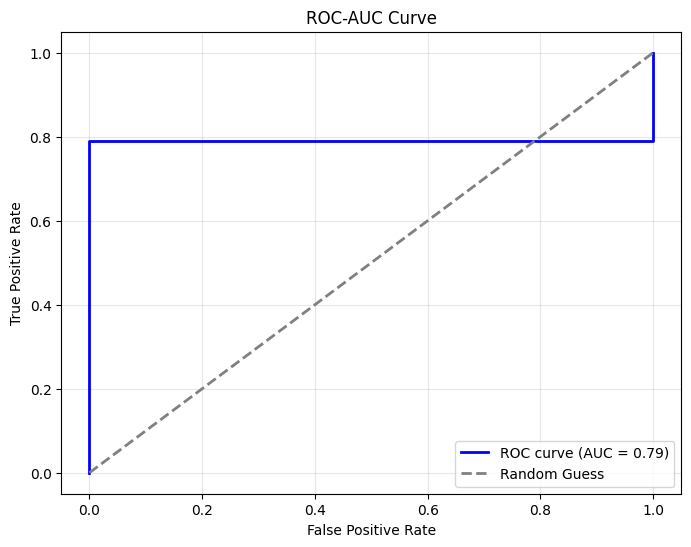

In [52]:
fpr, tpr, thresholds = roc_curve(y_test_binary, predictions)
roc_auc_value = auc(fpr, tpr)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc_value:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

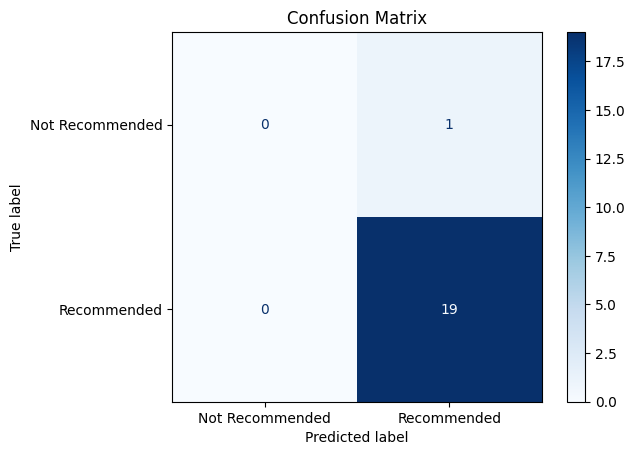

Precision: 0.9500
Recall: 1.0000


In [53]:
cm = confusion_matrix(y_test_binary, y_pred_binary)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Recommended", "Recommended"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


precision = precision_score(y_test_binary, y_pred_binary)
recall = recall_score(y_test_binary, y_pred_binary)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

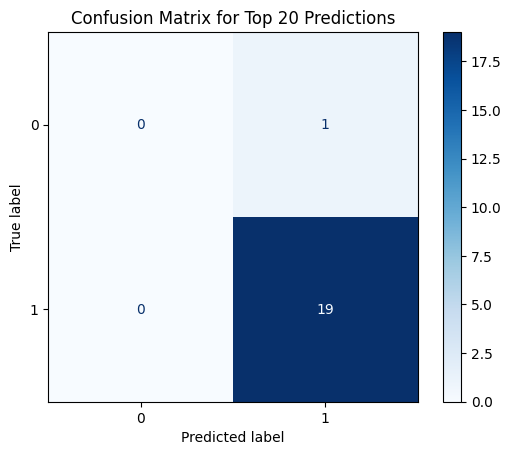

Precision for Top 20: 0.9500
Recall for Top 20: 1.0000


In [54]:
K = 20
top_k_indices = np.argsort(predictions.flatten())[-K:]
y_pred_top_k = y_pred_binary[top_k_indices].flatten()
y_test_top_k = y_test_binary[top_k_indices].flatten()
all_labels = [0, 1]
cm_top_k = confusion_matrix(y_test_top_k, y_pred_top_k, labels=all_labels)
disp_top_k = ConfusionMatrixDisplay(confusion_matrix=cm_top_k, display_labels=all_labels)
disp_top_k.plot(cmap="Blues")
plt.title(f"Confusion Matrix for Top {K} Predictions")
plt.show()
precision_top_k = precision_score(y_test_top_k, y_pred_top_k, labels=all_labels, zero_division=0)
recall_top_k = recall_score(y_test_top_k, y_pred_top_k, labels=all_labels, zero_division=0)
print(f"Precision for Top {K}: {precision_top_k:.4f}")
print(f"Recall for Top {K}: {recall_top_k:.4f}")
